## Toy example: Inferring the mean of Gaussians

#### comparing the multi-round SNPE approach against our new incremental approach.

Goal of this little toy example is to show that provided our parameters are independent of each other, we need less simulations to derive a good approximation of our parameters.

In [1]:
import sys
sys.path.append('../code/')

import utils
from utils.helpers import get_time
from utils import inference

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

from utils.simulation_wrapper import SimulationWrapper


# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def Gaussian(thetas, normal_noise=0.1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1000)
        
        gauss_list.append(s)
        
    gauss_list = [item for sublist in gauss_list for item in sublist]
    
    gauss_np = np.array(gauss_list)
    
    return gauss_np
    



In [3]:
true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])

Gaussians = []

gauss = Gaussian(true_thetas[0], 0.5)
    

    

(8000,)


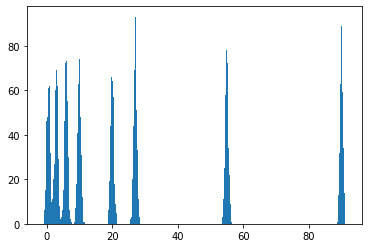

In [4]:
plt.hist(gauss, bins=1000)

print(gauss.shape)

In [5]:
def sum_stats(gauss):
    #gauss = torch.from_numpy(gauss)
    mean = torch.mean(gauss, dim=1)
    std = torch.std(gauss, dim=1)
    stats = torch.stack([mean, std], dim=1)
    
    return stats

for gauss in Gaussians:
    print(sum_stats(gauss))

In [6]:
prior_max = [100] * 8
prior_min = [0] * 8

print(prior_max)

[100, 100, 100, 100, 100, 100, 100, 100]


### Starting with the Multi-round SNPE approach

In [21]:
from sbi import utils as utils

num_simulations = 10000

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
inf = SNPE_C(prior, density_estimator="mdn")
simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

proposal = prior

for i in range(8):

    theta, x_without = simulate_for_sbi(
        simulator_stats,
        proposal=proposal,
        num_simulations=num_simulations,
        num_workers=8,
    )
    
    x = sum_stats(x_without)


    inf = inf.append_simulations(theta, x)
    density_estimator = inf.train()

    posterior = inf.build_posterior(density_estimator)
    
    obs_real = Gaussian(true_thetas[0])

    obs_real_stats = sum_stats(torch.tensor([obs_real]))
    
    proposal = posterior.set_default_x(obs_real_stats)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 35 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 130 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 52 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 57 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 51 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 25 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 81 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 52 epochs.


In [29]:
num_samples = 10000

samples = posterior.sample((num_samples,), x=obs_real_stats)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.05

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([0.0070, 0.0054, 0.0062, 0.0020, 0.0054, 0.0033, 0.0018, 0.0021])
tensor([99.9883, 98.9853, 99.8401, 78.7195, 74.4491, 99.8139, 94.7143, 87.4641])
tensor([4.9991, 4.9490, 4.9917, 3.9359, 3.7222, 4.9905, 4.7356, 4.3731])


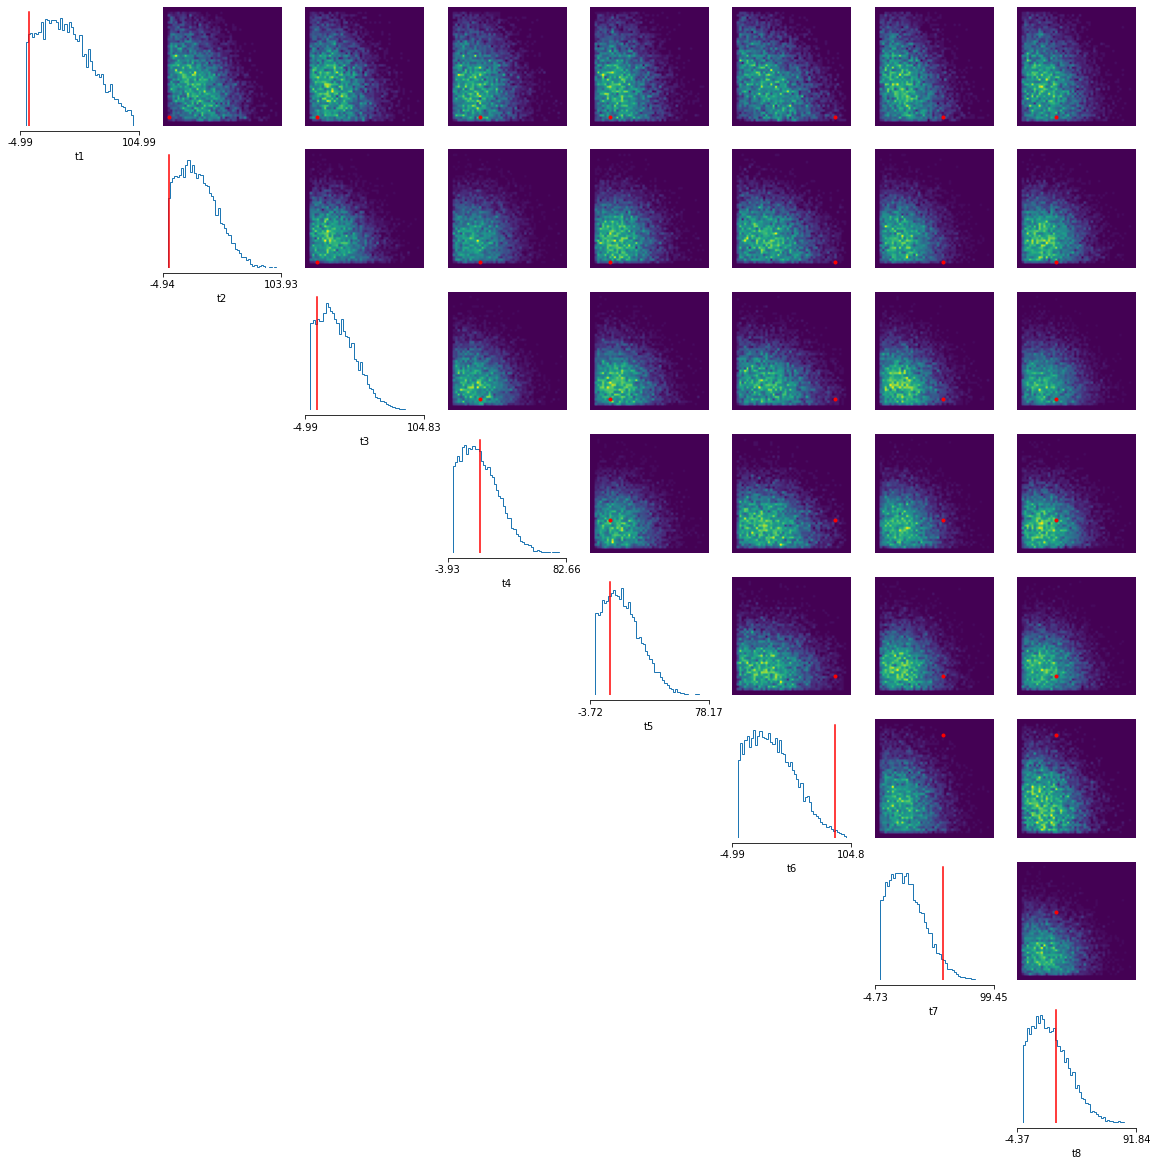

In [31]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]
true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(20, 20),
    points=true_thetas,
    points_offdiag={"markersize": 6},
    points_colors="r",
    tick_labels=np.round(limits,2),
    labels=parameter_names,
)

### Now we do the same, but with the incremental approach:

In [11]:
import datetime
range_list = [1,2,3,4,5,6,7,8]
num_simulations = 1000

true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])

prior_i = utils.torchutils.BoxUniform(low=prior_min[0:1], high = prior_max[0:1])
inf = SNPE_C(prior_i, density_estimator="mdn")
simulator_stats, prior_i = prepare_for_sbi(Gaussian, prior_i)

obs_real = Gaussian([true_thetas[0, 0]])

obs_real_stats = sum_stats(torch.tensor([obs_real]))

print(obs_real_stats)

for index in range(len(range_list)-1):

    ## i defines number of parameters to be inferred, j indicates how many parameters 
    #to come in the next round
    i = range_list[index]
    j = range_list[index+1]

    print(i, j)


    start_time = datetime.datetime.now()

    theta, x_without =  simulate_for_sbi(
        simulator_stats,
        proposal=prior_i,
        num_simulations=num_simulations,
        num_workers=8,
        
    )


    x = sum_stats(x_without)
    inf = inf.append_simulations(theta, x)
    neural_dens = inf.train()

    posterior = inf.build_posterior(neural_dens)
    
    if i < 2:
        obs_real = Gaussian([true_thetas[0, 0:i]])
        
    else:
        obs_real = Gaussian(true_thetas[0, 0:i])

    obs_real_stats = sum_stats(torch.tensor([obs_real]))

    proposal1 = posterior.set_default_x(obs_real_stats)

    next_prior = utils.torchutils.BoxUniform(low=prior_min[i:j], high=prior_max[i:j])

    combined_prior = Combined(proposal1, next_prior, number_params_1=i)


    ## set inf for next round:
    inf = SNPE_C(combined_prior, density_estimator="mdn")


    ## set combined prior to be the new prior_i:
    prior_i = combined_prior
    
    finish_time = datetime.datetime.now()
    
    diff = finish_time - start_time
    
    print('took ', diff, ' for this step')
    

tensor([[2.9977, 0.0987]], dtype=torch.float64)


In [14]:
prior_i.sample((100,)).shape

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

theta shape torch.Size([100, 8])


torch.Size([100, 8])

In [15]:
    
theta, x_without =  simulate_for_sbi(
    simulator_stats,
    proposal=prior_i,
    num_simulations=num_simulations,
    num_workers=8,

)


x = sum_stats(x_without)
inf = inf.append_simulations(theta, x)
neural_dens = inf.train()

posterior = inf.build_posterior(neural_dens) 

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta shape torch.Size([1000, 8])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 63 epochs.


In [16]:
obs_real = Gaussian(true_thetas[0, :])

print(obs_real.shape)

obs_real_stats = sum_stats(torch.tensor([obs_real]))

print(obs_real_stats.shape)

posterior.set_default_x(obs_real_stats)

(8000,)
torch.Size([1, 2])


In [17]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=obs_real_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
samples.shape

torch.Size([1000, 8])

In [19]:
list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.05

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([ 1.7445, -1.4275,  1.2699, 15.3842,  4.7776, 87.6409, 41.0744, 13.7452])
tensor([ 6.6532,  2.1585,  8.1022, 25.7761, 13.8566, 94.0246, 71.3495, 36.5555])
tensor([0.2454, 0.1793, 0.3416, 0.5196, 0.4539, 0.3192, 1.5138, 1.1405])


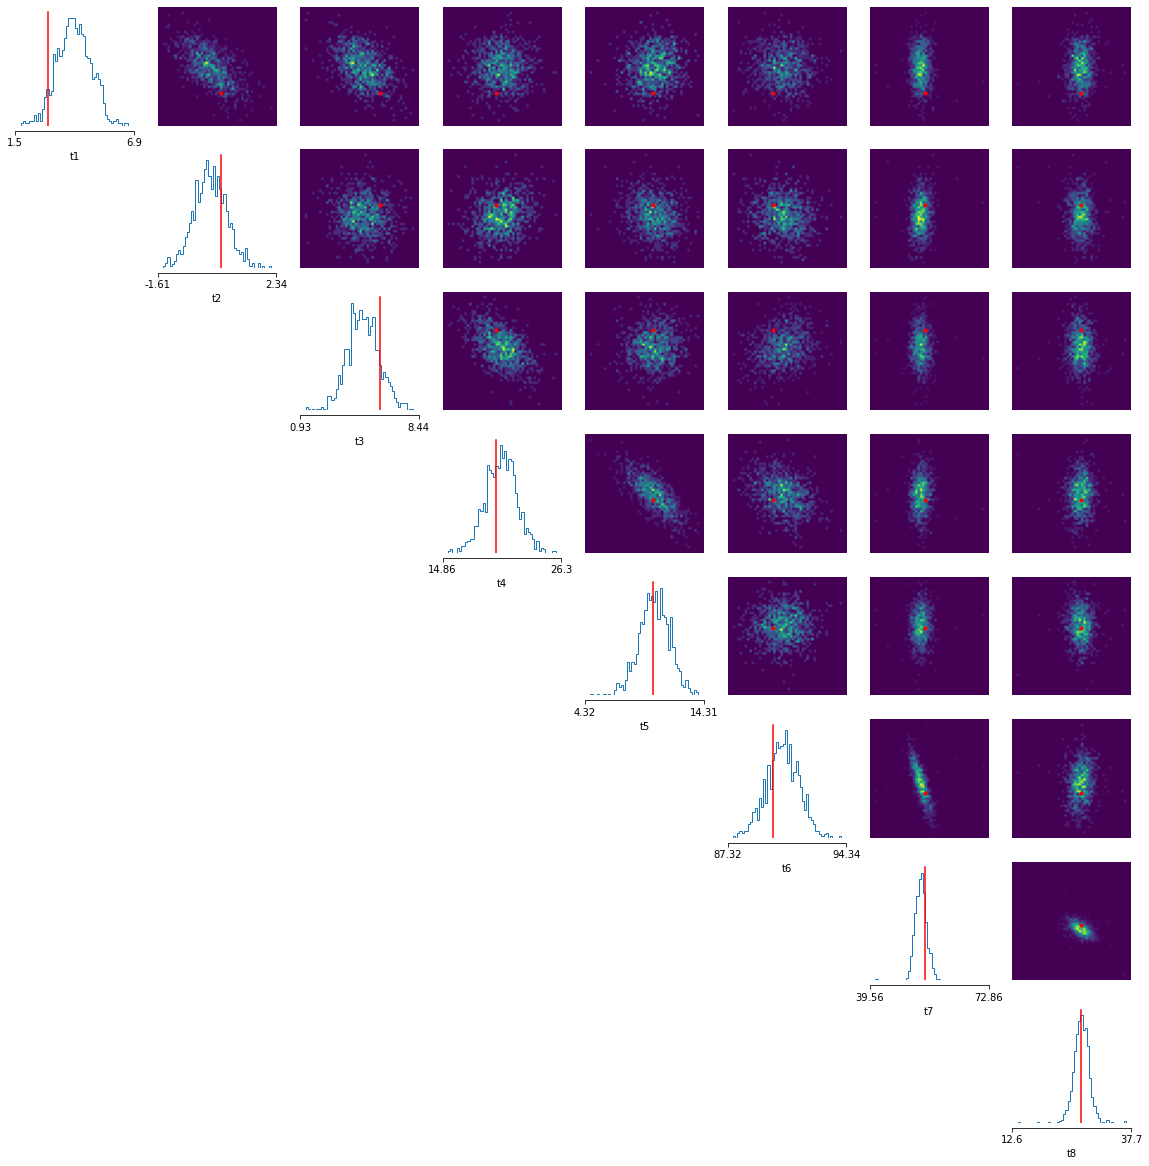

In [20]:
true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=np.round(limits, 2),
    figsize=(20, 20),
    points=true_thetas,
    points_offdiag={"markersize": 6},
    points_colors="r",
    tick_labels=np.round(limits,2),
    labels=parameter_names,
)

### Larger comparison with KL-divergence between analytic and inferred posterior

In [32]:
from math import log2

def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [35]:
posterior.sample((10,)).shape

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([10, 8])

In [50]:
### analytic posterior:

analytic = torch.distributions.normal.Normal(true_thetas, 0.1)




Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

### Calculate posterior for different number of simulations: 1k,  3k, 5k, 10k

### starting with multi-round snpe

In [53]:
num_simulations_list = [1000, 3000, 5000, 10000]

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
inf = SNPE_C(prior, density_estimator="mdn")
simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

proposal = prior

posterior_snpe_list = []

for num_simulations in num_simulations_list:

    for i in range(8):

        theta, x_without = simulate_for_sbi(
            simulator_stats,
            proposal=proposal,
            num_simulations=num_simulations,
            num_workers=8,
        )

        x = sum_stats(x_without)


        inf = inf.append_simulations(theta, x)
        density_estimator = inf.train()

        posterior = inf.build_posterior(density_estimator)

        obs_real = Gaussian(true_thetas[0])

        obs_real_stats = sum_stats(torch.tensor([obs_real]))

        proposal = posterior.set_default_x(obs_real_stats)

    posterior_snpe = posterior
    
    posterior_snpe_list.append(posterior_snpe)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 51 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 40 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 29 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 51 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 31 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 118 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 42 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 96 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 35 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 49 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 113 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 50 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 55 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 65 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 23 epochs.


Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Running 3000 simulations in 3000 batches.:   0%|          | 0/3000 [00:00<?, ?it/s]

Neural network successfully converged after 99 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 49 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 88 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 161 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 113 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 247 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 176 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 241 epochs.


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

Neural network successfully converged after 75 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 71 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

Neural network successfully converged after 39 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### For incremental approach: 

In [ ]:
range_list = [1,2,3,4,5,6,7,8]


true_thetas = torch.tensor([[3, 0.5, 6, 20, 10, 90, 55, 27]])

posterior_incremental_list = []

prior_i = utils.torchutils.BoxUniform(low=prior_min[0:1], high = prior_max[0:1])
inf = SNPE_C(prior_i, density_estimator="mdn")
simulator_stats, prior_i = prepare_for_sbi(Gaussian, prior_i)

obs_real = Gaussian([true_thetas[0, 0]])

obs_real_stats = sum_stats(torch.tensor([obs_real]))

for num_simulations in num_simulations_list:

    for index in range(len(range_list)-1):

        ## i defines number of parameters to be inferred, j indicates how many parameters 
        #to come in the next round
        i = range_list[index]
        j = range_list[index+1]

        print(i, j)


        start_time = datetime.datetime.now()

        theta, x_without =  simulate_for_sbi(
            simulator_stats,
            proposal=prior_i,
            num_simulations=num_simulations,
            num_workers=8,

        )


        x = sum_stats(x_without)
        inf = inf.append_simulations(theta, x)
        neural_dens = inf.train()

        posterior = inf.build_posterior(neural_dens)

        if i < 2:
            obs_real = Gaussian([true_thetas[0, 0:i]])

        else:
            obs_real = Gaussian(true_thetas[0, 0:i])

        obs_real_stats = sum_stats(torch.tensor([obs_real]))

        proposal1 = posterior.set_default_x(obs_real_stats)

        next_prior = utils.torchutils.BoxUniform(low=prior_min[i:j], high=prior_max[i:j])

        combined_prior = Combined(proposal1, next_prior, number_params_1=i)


        ## set inf for next round:
        inf = SNPE_C(combined_prior, density_estimator="mdn")


        ## set combined prior to be the new prior_i:
        prior_i = combined_prior

        finish_time = datetime.datetime.now()

        diff = finish_time - start_time

        print('took ', diff, ' for this step')
        
    theta, x_without =  simulate_for_sbi(
        simulator_stats,
        proposal=prior_i,
        num_simulations=num_simulations,
        num_workers=8,

    )


    x = sum_stats(x_without)
    inf = inf.append_simulations(theta, x)
    neural_dens = inf.train()

    posterior_incremental = inf.build_posterior(neural_dens) 
    
    posterior_incremental_list.append(posterior_incremental)
    

In [51]:
import torch.nn.functional as F


out = F.kl_div(analytic_sample, posterior_sample)

In [ ]:
def calc_KL(posterior):
    
    sample = posterior.sample((10000,))
    
    analytic = torch.distributions.normal.Normal(true_thetas, 0.1)
    
    analytic_sample = analytic.sample((10000,))
    
    out = F.kl_div(analytic_sample, sample)
    
    return out



In [ ]:
KL_snpe = []

for posterior_snpe in posterior_snpe_list:
    
    KL = calc_KL(posterior_snpe)
    
    KL_snpe.append(KL)



KL_incremental = []

for posterior_incremental in posterior_incremental_list:
    
    KL = calc_KL(posterior_incremental)
    
    KL_incremental.append(KL)
    
    

### Compare KL-divergence of snpe approach with incremental approach in a plot:

#### x = number of simulations per round/step

In [ ]:
plt.plot(KL_incremental)
plt.plot(KL_snpe)

